# Introduction

This is my attempt for [Kaggle's Housing Price Competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), where participants have to use regression techniques in order to predict housing prices. 

In order to accomplish my goal of accurately predicting housing prices, I will perform EDA on the given training dataset. This will allow me to see trends and patterns that may prove useful when I build the prediction model down the line. 

More specifically, I will first try to understand the data overall (i.e. the number and variety of predictors, the number of entries, etc.), then analyze the dependent variable (the housing price) and the independent variables. Afterwards, I will perform some basic cleaning like dealing with outliers and missing data, feature engineering and feature extracting.

This portion of this project is heavily inspired by [Pedro Marcelino's data exploration of this competition](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#COMPREHENSIVE-DATA-EXPLORATION-WITH-PYTHON) as well as [this other Kaggle notebook](https://www.kaggle.com/dgawlik/house-prices-eda/notebook).

Finally, I will create my model and submit my predictions using the provided testing dataset to the Kaggle leaderboard, and report what rank I get.

# Taking a Look at the Data...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression

import math

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
data.shape

(1460, 81)

Above, we see that there are 1460 entries with 81 variables. One of these variables (`SalePrice`) is our dependent variable, and is the value we are trying to predict. Another variable (`Id`) is simply used to mark unique entries, and will not help our model predict `SalePrice`. 

So, **each entry has 79 independent variables and 1 dependent variable.**
The descriptions for these variables can be found in `data_description.txt`.

Looking through these variables, I have chosen these variables as expected to be important in predicting the house's price. Of course, this is done at first glance and this is going off of a simple, preliminary peek at the variables.

| Variable Name | Type | Description | Why I think this is important |
|----------------|--------------|----------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
| `GrLivArea` | Quantitative | Above grade (ground) living area square feet` | The size of the actual living space is a characteristic of homes that seems to most coincide with the home's price. |
| `LotArea` | Quantitative | Lot size in square feet | The size of the whole property seems important (as opposed to just the living space), as larger properties tend to be more expensive. |
| `Neighborhood` | Categorical | Physical locations within Ames City Limits | The location of the property is an important variable, as properties in nicer places are more expensive. |
| `OverallQual` | Categorical | Rates the overall material and finish of the house (from 1-10) | Though I am not sure how this was calculated, this can show that higher rated properties have higher prices. |
| `YearBuilt` | Categorical | Original construction date | Older homes may have an impact on the price of the house, and may have different prices than newer homes. |
| `PoolQC` | Categorical | Pool Quality | Some homes do not have a pool, and as such, these homes would be less expensive than those with pools. |
| `TotalBsmtSF`` | Quantitative | Total square feet of basement area | The size of the basement seems like it could determine which homes are more expensive, as larger basements could be found in more expensive houses. |

**Note: Again, this is going off of a simple peek at the variables.**

Other than the seemingly 'subjective' variables (`OverallQual`), we see that six of the seven variables that I deemed important have to do with the physical characteristics of the building itself, where as one variable (`Neighborhood`), has to do with the location of the home.

In general, I chose variables that were more broad. For example, instead of looking at the number of bedrooms in the home (`Bedrooms`), I instead chose `GrLivArea`, which seems to encompass the area of living space above ground already. This is done to try and avoid confounding. There do exist other 'subjective' variables, such as the quality of the garage (`GarageQual`) and quality of the exterior of the house (`ExterQual`). I chose `OverallQual` instead, as I believe that this variable encompasses the other subjective variables, as it is looking at the house _overall_.

I also chose `OverallQual` and not `OverallCond` because I believed that the ideas were redundant with each other - a house with a 10 on `OverallQual` will most likely have a similar high score on `OverallCond`.


In [4]:
# Get list of quantitative and qualitative variables
quant = [f for f in data.columns if data[f].dtype != 'object']
quant.remove('Id')
quant.remove('SalePrice')
qual = [f for f in data.columns if data[f].dtype == 'object']

# `SalePrice`: The Dependent Variable

As said before, the variable we are trying to predict for this competition is the final sales price of the house, measured by the `SalePrice` column in the dataset.

In [5]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

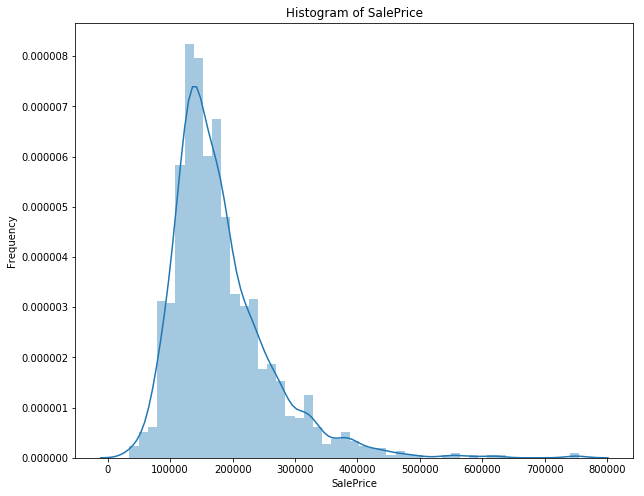

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Histogram of SalePrice')
ax.set_ylabel('Frequency')
ax = sns.distplot(data['SalePrice'])
plt.show()

In [7]:
print('Skewness:', data['SalePrice'].skew())
print('Kurtosis:', data['SalePrice'].kurtosis())

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


Some notable characteristics from looking at this information:

- The mean `SalePrice` is around \\$180k, which is lower than today's average of about \\$220k (as of 1/6/2020) in Ames, Iowa, where this dataset is taken from. As such, this dataset is not up-to-date.
- The minimum housing price is about \\$3400, and not a negative number or 0, showing that the housing prices were recorded properly.
- The maximum housing price is about \\$755k, which seems to be an outlier given the mean. 
- **Skewness measures lack of symmetry of a graph**, where symmetry is defined as a graph looking similar on the left side of the center point as on the right side. 0 represents a perfectly symmetrical graph i.e. a normal distribution. Values farther from 0 show more skewed distributions. In this case, we see that the data is skewed to the right given the positive value for the skewness. [Cited from here.](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm)
- **Kurtosis measures the tailedness of the distribution**, and whether or not it is 'heavily-tailed' or 'light-tailed' in relation to the normal distribution. The standard normal distribution has a kurtosis of 0, and positive values indicate a distribution with a heavier tale, as in this case. [Cited from here.](https://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm)
- Looking at the graph, one can see that this is a **unimodal distribution skewed heavily towards increasing sales prices**. Let us test and see whether or not our intuitions are correct and check the normality of this distribution.


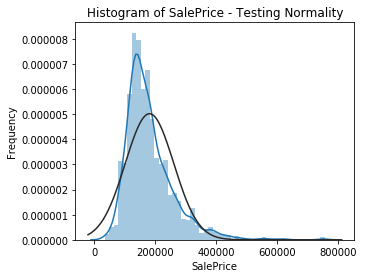

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Histogram of SalePrice - Testing Normality')
ax.set_ylabel('Frequency')
ax = sns.distplot(data['SalePrice'], fit = norm)
plt.show()

Above, the blue line is the gaussian kernel density estimate of the histogram, which is a way of predicting the probability density function of `SalePrice`. The black line is the maximum likelihood gaussian distribution fit of the data. These two lines should be similar with each other if the data were normal. This implies that `SalePrice` is not normal.

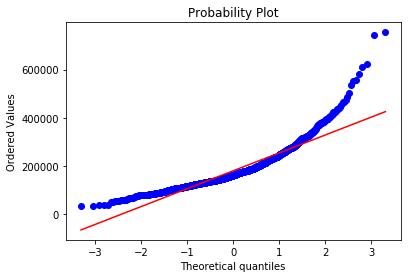

In [9]:
res = stats.probplot(data['SalePrice'], plot=plt)

This is a [probability plot](https://www.itl.nist.gov/div898/handbook/eda/section3/probplot.htm) of the data (blue dots) and of the normal distribution (red line). A probability plot is a graphical means of verifying if a given distribution is similar to another theoretical distribution (such as the normal distribution). The points are plotted in such a way that they should form a straight, diagonal line. Deviations from a straight line imply that it is not like the theoretical distribution it is being compared with. 

These two lines should be similar if the data were normal, thus implying again that `SalePrice` is not normal. 

To deal with non-normality, we can simply transform the data. There are many methods for transforming the data, including applying a [Johnson SU transformation](https://en.wikipedia.org/wiki/Johnson%27s_SU-distribution) or by [applying the log function to the data](http://onlinestatbook.com/2/transformations/log.html). Given the positive skewness of this problem, I will use log transformation for `SalePrice`.

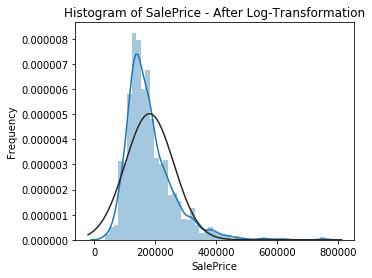

In [10]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.set_title('Histogram of SalePrice - After Log-Transformation')
ax.set_ylabel('Frequency')
ax = sns.distplot(data['SalePrice'], fit = norm)
plt.show()

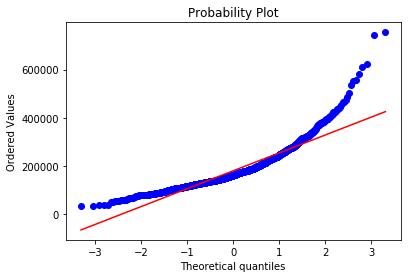

In [11]:
res = stats.probplot(data['SalePrice'], plot=plt)

After the transformation, we see that the data now closely resembles a normal distribution, and as such, statistical tests can be applied to `SalePrice`. Another problem that ensuring `SalePrice` is normal solves is the issue of [heteroscedasticity](https://www.statisticssolutions.com/homoscedasticity/), which describes where an error term (the 'noise' involved in the problem), is different across all values of an independent variable. This is an issue given that it would be difficult to create a regression model when heteroscedasticity is present, as there would be great variety in an independent variable i.e. a cone shape would form from plotting this independent variable. As such, we 'stabilize' this variety by transforming the dependent variable.

## Conclusion

`SalePrice` was originally a unimodal, skewed, non-normal distribution taking on quantitative values. To transform the data, we took the log of each of the values of `SalePrice`, and were able to create a new distribution extremely close to normal. This method can be done to other quantitative variables, as well. 

# Independent Variables: The Other Guys

Above, I have already talked about the variables I believe will have a great impact on `SalePrice`. This was done for me to take a brief glimpse at what was measured when this dataset was made, as well as note my personal expectations. Here they are again, for convenience.

| Variable Name | Type | Description | Why I think this is important |
|----------------|--------------|----------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------|
| `GrLivArea` | Quantitative | Above grade (ground) living area square feet` | The size of the actual living space is a characteristic of homes that seems to most coincide with the home's price. |
| `LotArea` | Quantitative | Lot size in square feet | The size of the whole property seems important (as opposed to just the living space), as larger properties tend to be more expensive. |
| `Neighborhood` | Categorical | Physical locations within Ames City Limits | The location of the property is an important variable, as properties in nicer places are more expensive. |
| `OverallQual` | Categorical | Rates the overall material and finish of the house (from 1-10) | Though I am not sure how this was calculated, this can show that higher rated properties have higher prices. |
| `YearBuilt` | Categorical | Original construction date | Older homes may have an impact on the price of the house, and may have different prices than newer homes. |
| `PoolQC` | Categorical | Pool Quality | Some homes do not have a pool, and as such, these homes would be less expensive than those with pools. |
| `TotalBsmtSF` | Quantitative | Total square feet of basement area | The size of the basement seems like it could determine which homes are more expensive, as larger basements could be found in more expensive houses. |

## Missing Values

Since we are now taking a look at the independent variables, it would be helpful to see which variables are missing, and if there is a good reason as to why such variables have missing entries.

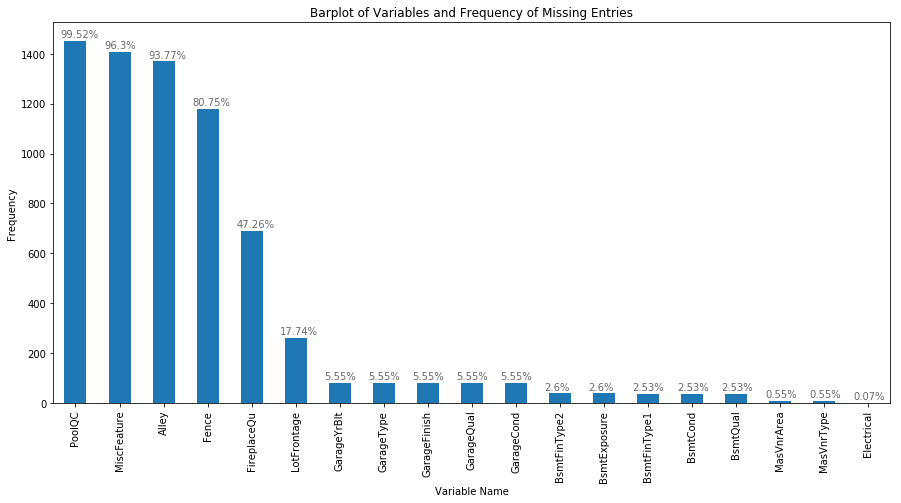

In [12]:
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True, ascending = False)

ax = missing.plot(kind='bar', figsize=(15,7))
ax.set_alpha(0.8)
ax.set_title("Barplot of Variables and Frequency of Missing Entries")
ax.set_ylabel("Frequency")
ax.set_xlabel('Variable Name')

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()-.10, i.get_height()+15, \
            str(round((i.get_height()/len(data))*100, 2))+'%', fontsize=10,
                color='dimgrey')

In the barplot above, we can see all of the variables that have missing entries, and how many entries in the original dataset have a missing value in the particular variable. The percentage above each bar represents the proportion of data that is missing for that variable.

For example, there are over 1400 observations without a reported value for `PoolQC` in the data. This translates to 99.52% of the original data missing a value for `PoolQC`.

### Dealing with These Variables 

The first five variables in the bar plot (`PoolQC` to `FireplaceQu`), have lots of missing data. In fact, over a quarter of the data is missing values for all of these variables (in fact, `PoolQC`, `MiscFeature`, and `Alley` are missing in over 90% of the data). Such large amounts of missing data suggests that there is a pattern and that these are not random mistakes done in data gathering, which is a common reason as to why missing values exist in the first place.

The only variable that is present on my table and has missing data is `PoolQC`. Given that many homes do not have pools, it would make sense that some entries would be empty. You cannot rate the quality of your pool if you do not have any. As such, we can treat the missing data as another level for `PoolQC`. 

This kind of treatment, where we fill in values for the missing entries, is called **imputation**. It is common to do so for variables that have a lot of missing data.

Note that I am performing imputation on all of the categorical variables with missing data. Typically, this is done on variables with lots of missing data, which can be determined by some arbitrary threshold. Another method of dealing with missing data is by simply deleting the observations with the missing data. For example, only 0.07% of the data is missing a value for `Electrical`. So, I could simply delete the observations that are missing this value. 

However, I will not do this because our dataset is not very large to begin with, having only 1460 observations. Deletion would be much safer in larger datasets, as you are not losing out on important information that could be vital in making your prediction model down the line.

In [13]:
# Get the categorical variables 
categ_vars = [var for var in missing.index.values if data[var].dtype == 'object']

# Imputation
for categ_var in categ_vars:
    data[categ_var] = data[categ_var].fillna('MISSING')

`GarageYrBlt` is an interesting variable as it is recorded as a quantitative variable in the dataset. It makes better sense to use this variable categorically i.e. each year is a different category. Afterall, it would be difficult to find the average year or median year. 

One way to impute this would be to fill in the missing entries with the values found in `YearBuilt`, since most homes have had their garage built in the same year the home was originally constructed. Almost 75% of the homes in the dataset have had their garages built in the same year as the original construction of the house, so it would be a safe bet to impute the entries with the same year.

In [14]:
print('Proportion of data where YearBuilt and GarageYrBlt are the same:', 
      data[data['GarageYrBlt'] == data['YearBuilt']].shape[0] / len(data) * 100, '%')

Proportion of data where YearBuilt and GarageYrBlt are the same: 74.58904109589041 %



However, this can lead to confounding between the variables, which can affect the model's performance. `GarageYrBlt` would be redundant, in this case, in terms of presenting information about the house. We only want the most relevant variables, or the models that capture the most information, for our model.

So, I will instead impute `GarageYrBlt` with another level for missing data.

In [15]:
data['GarageYrBlt'] = data['GarageYrBlt'].fillna('MISSING')
quant.remove('GarageYrBlt')

For the quantitative variables `LotFrontage` and `MasVnrArea`, I will impute the missing data using linear regression. I could simply impute the means of these variables into the missing data, but based on my experience in [competing in Kaggle's Titanic Challenge](https://github.com/philliplagoc/Kaggle-Titanic/blob/master/Titanic!.ipynb), imputation via regression seems to make more sense, as the imputed values would, hopefully, make much more sense for the entries.

In order to do this linear regression, I will simply one-hot encode the categorical variables, and remove the other variables with missing data from training the model.

In [16]:
def impute_quant(df, var):
    """
    Imputes the missing quantitative data using simple linear regression. 
    The dependent variable is the variable with missing entries, and the 
    independent variables are everything else (excluding ID and SalePrice).
    Linear regression requires the categorical variables to be encoded and no missing values.
    For simplicity, I drop the variables with missing data from the regression model, and one-hot 
    encode the categorical variables.

    Params:
      df - The name of the DataFrame where the variable is stored.
      var - The name of the variable to impute.

    Returns the predictions made for the missing data.
    """
    holdout = df[var] # Keeps the missing values from the column of interest
    # Remove all of the columns with missing values except for the column of interest
    temp_df = df.dropna(axis = 'columns')
    temp_df = pd.get_dummies(temp_df, columns = [col for col in temp_df.columns if temp_df[col].dtype == 'object'])
    temp_df[var] = holdout
        
    # Get the training and testing data
    temp_train = temp_df.loc[temp_df[var].notna()]        
    temp_test = temp_df.loc[temp_df[var].isnull()]
    
    if('SalePrice' in df.columns):
        # Split the data into X and y portions
        temp_train_X = temp_train.loc[:, ~temp_train.columns.isin(['SalePrice', 'Id', var])]
        temp_test_X = temp_test.loc[:, ~temp_test.columns.isin(['SalePrice', 'Id', var])]

        temp_train_y = temp_train.loc[:, var]

        # Imputation via linear regression 
        logreg = LinearRegression().fit(temp_train_X, temp_train_y)
        preds = logreg.predict(temp_test_X)
    
        return preds
    else:
        # Split the data into X and y portions
        temp_train_X = temp_train.loc[:, ~temp_train.columns.isin(['Id', var])]
        temp_test_X = temp_test.loc[:, ~temp_test.columns.isin(['Id', var])]

        temp_train_y = temp_train.loc[:, var]

        # Imputation via linear regression 
        logreg = LinearRegression().fit(temp_train_X, temp_train_y)
        preds = logreg.predict(temp_test_X)
    
        return preds

In [17]:
# Impute the quantitative variables
for var in ['LotFrontage', 'MasVnrArea']:
    data.loc[data[var].isnull(), var] = impute_quant(data, var)


Now, we can take a look at the variables I listed in the table above. I will start with the quantitative variables.

### GrLivArea

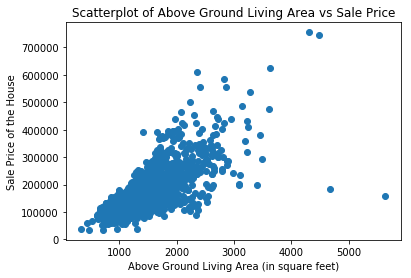

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Scatterplot of Above Ground Living Area vs Sale Price')
ax.set_ylabel('Sale Price of the House')
ax.set_xlabel('Above Ground Living Area (in square feet)')
ax.scatter(data['GrLivArea'], data['SalePrice'])
plt.show()

We see a positive, almost linear relationship between `GrLivArea` and `SalePrice`. `GrLivArea` is also a great example of heteroscedasticity. Here we see that the value of `GrLivArea` itself varies greatly from cheaper to more expensive houses. In other words, smaller houses tend to have a tighter range of prices, whereas larger houses tend to have a wider price range.

Because of this, we can expect to that `GrLivArea` will be non-normal. Below are the same tests for normality we used for `SalePrice`. 

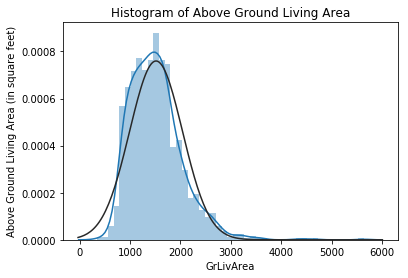

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Histogram of Above Ground Living Area')
ax.set_ylabel('Above Ground Living Area (in square feet)')
ax = sns.distplot(data['GrLivArea'], fit = norm)
plt.show()

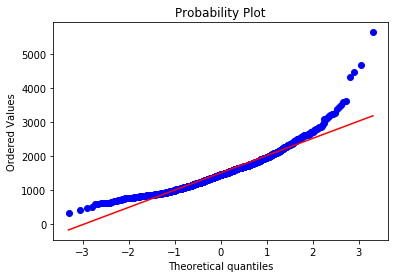

In [20]:
res = stats.probplot(data['GrLivArea'], plot=plt)

Looks like `GrLivArea` is not normal as well. This can be solved with a simple log-transformation, similar to how `SalePrice` was transformed.

### LotArea

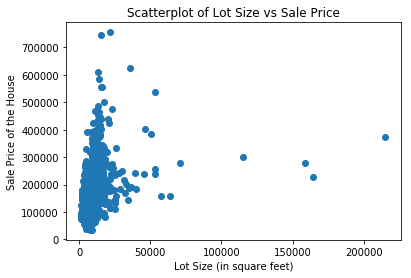

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Scatterplot of Lot Size vs Sale Price')
ax.set_ylabel('Sale Price of the House')
ax.set_xlabel('Lot Size (in square feet)')
ax.scatter(data['LotArea'], data['SalePrice'])
plt.show()

I expected that larger lot sizes, in general, would result in higher prices. However, this graph shows that homes with lot sizes of over 100,000 square feet are not the most expensive houses. This, along with the large cluster on the left seems to suggest that lot size does not have as big as an effect on `SalePrice` as I had initially thought. Though larger lot sizes are found in more expensive homes, the sizes of these lots do not vary a lot themselves i.e. lot size varies less than `SalePrice`.
Additionally, there are some homes with extremely large lot sizes but are actually cheaper than expected. This suggests that these homes are outliers. For now, I will keep them because this may be important in making the model. Perhaps these homes were farms with lots of space for crops and livestock. It would be beneficial for the end-model to capture such observations.

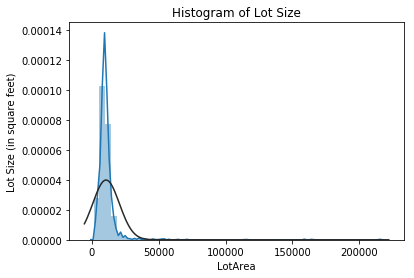

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Histogram of Lot Size')
ax.set_ylabel('Lot Size (in square feet)')
ax = sns.distplot(data['LotArea'], fit = norm)
plt.show()

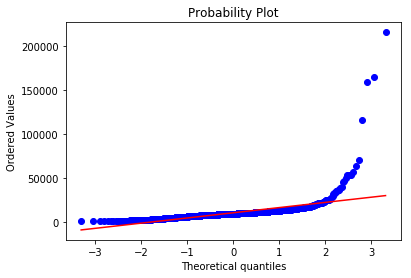

In [23]:
res = stats.probplot(data['LotArea'], plot=plt)

Again, this distribution seems to not be normal, and a transformation is needed.

### TotalBsmtSF

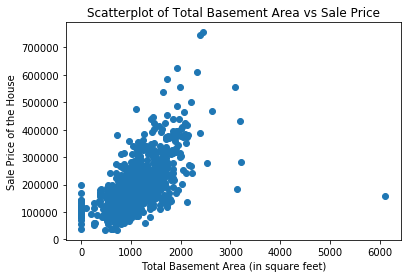

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Scatterplot of Total Basement Area vs Sale Price')
ax.set_ylabel('Sale Price of the House')
ax.set_xlabel('Total Basement Area (in square feet)')
ax.scatter(data['TotalBsmtSF'], data['SalePrice'])
plt.show()

We see a cone-shape again, suggesting that a transformation of this data is needed. Other than that, there seems to be a positive, almost linear relationship between `SalePrice` and the total area of the basement of the home. There seems to be one outlier as well.

There also are several observations with a `TotalBsmtSF` of 0, meaning that these homes will not have any basements.

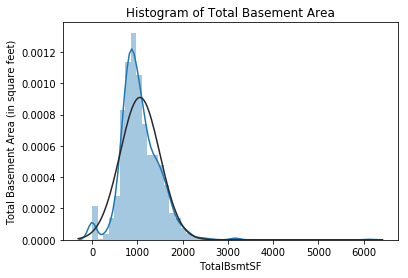

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Histogram of Total Basement Area')
ax.set_ylabel('Total Basement Area (in square feet)')
ax = sns.distplot(data['TotalBsmtSF'], fit = norm)
plt.show()

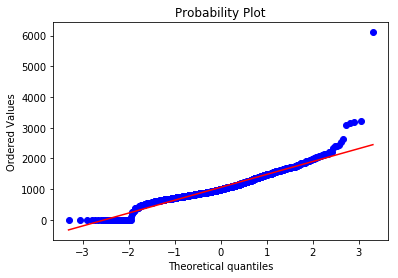

In [26]:
res = stats.probplot(data['TotalBsmtSF'], plot=plt)

We see that there is some skewness in the observation, suggesting a transformation is needed. However, there are several homes with a `TotalBsmtSF` of 0, meaning that these homes have no basements. This is a problem for our solution of simplifying transforming the values via a log transformation, as it does not work with values of 0. As such, I will create a new binary variable that shows if a given house has a basement. On homes with a basement, the log-transformation will be applied.

This may be found in other quantitative variabels as well, so applying these extra steps would also be necessary.

In [27]:
# Example of what must be done to similar variables. Performed in-depth below.
# data['HasBsmt'] = data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

Now, let's take a look at the categorical variables and their relationship with `SalePrice`.

### Neighborhood

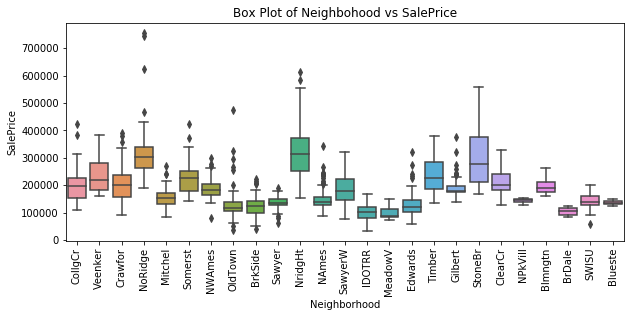

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Box Plot of Neighbohood vs SalePrice')
ax = sns.boxplot(x='Neighborhood', y="SalePrice", data=data)
x = plt.xticks(rotation=90)

It would seem that the prices for homes vary wildly depending on the location of the property. We can check how much it varies using an [One-Way ANOVA test](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/hypothesis-testing/anova/), which tests to see if experiment results are significant by checking whether or not groups are different. In this case, the groups are the different levels of `Neighborhood`, i.e. the 25 different neighborhoods present in the dataset.

In [29]:
# Get each level of Neighborhood
neighborhoods = data['Neighborhood'].unique()
all_neighborhoods = [] # List of lists for each neighborhood's sales price
for neighborhood in neighborhoods:
    # Get the SalePrice associated with each level of Neighborhood as a list
    sales = data[data['Neighborhood'] == neighborhood]['SalePrice'].values 
    all_neighborhoods.append(sales)

# ANOVA test
pval = stats.f_oneway(*all_neighborhoods)[1]
print('P-value:', pval)

P-value: 1.558600282771154e-225


For an ANOVA test, we use the null hypothesis stating that all levels of `Neighborhood` are the same i.e. there is no difference in `SalePrice` amongst the 25 different neighborhoods. Using an ANOVA test allows us to test this null hypothesis by giving us a [p-value](https://en.wikipedia.org/wiki/P-value), which quantifies the significance of our results. The **p-value is the probability of obtaining results as extreme as the ones shown in the test**, and so extremely low p-values (typically below some arbitrarily chosen significance level $\alpha$), mean that the chances of us observing such results due to chance are very low. As such, we can reject the null hypothesis.

In this case, our p-value is extremely small, showing us that we can reject the null hypothesis. The neighborhoods are significant in determining `SalePrice`.

### OverallQual

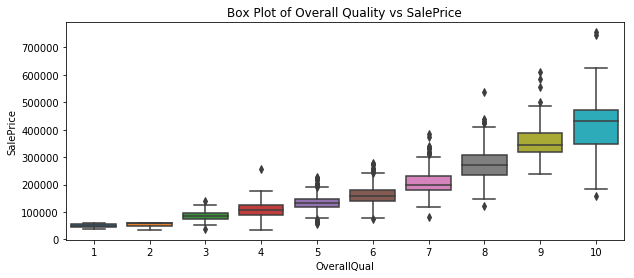

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Box Plot of Overall Quality vs SalePrice')
ax = sns.boxplot(x='OverallQual', y="SalePrice", data=data)

In [31]:
overall_quals = data['OverallQual'].unique()
all_quals = [] 
for overall_qual in overall_quals:
    sales = data[data['OverallQual'] == overall_qual]['SalePrice'].values 
    all_quals.append(sales)

# ANOVA test
pval = stats.f_oneway(*all_quals)[1]
print('P-value:', pval)

P-value: 0.0


Here we see that the p-value is not actually that small, suggesting that there may be a slight difference between the different categories of `OverallQual` in `SalePrice`. However, this depends on the significance level we choose. Typically, an $\alpha$ level of 0.05 is chosen. P-values lower than this suggest that we can reject the null hypothesis, and therefore say that the levels of `OverallQual` are significant when it comes to the final home's price.

### YearBuilt

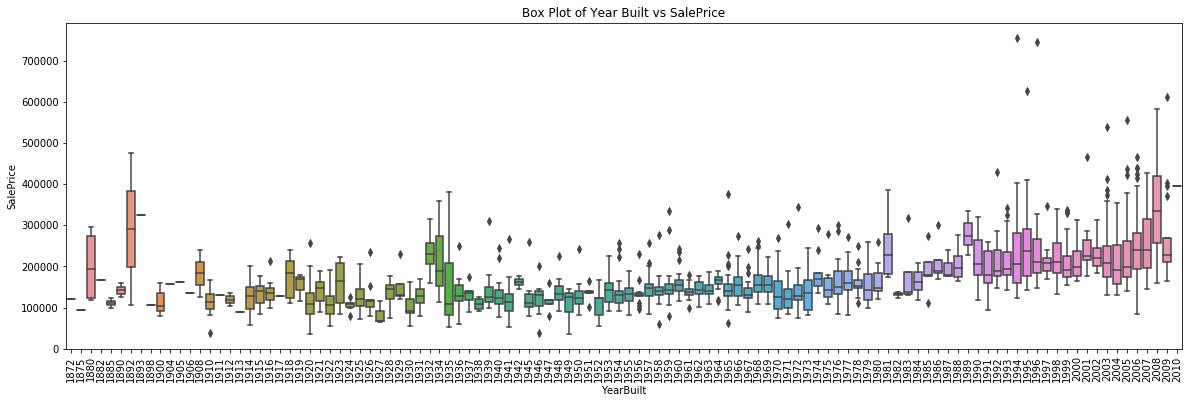

In [32]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.set_title('Box Plot of Year Built vs SalePrice')
ax = sns.boxplot(x='YearBuilt', y="SalePrice", data=data)
x = plt.xticks(rotation=90)

In [33]:
years = data['YearBuilt'].unique()
all_years = [] 
for year in years:
    sales = data[data['YearBuilt'] == year]['SalePrice'].values 
    all_years.append(sales)

# ANOVA test
pval = stats.f_oneway(*all_years)[1]
print('P-value:', pval)

P-value: 9.128103646611706e-107


The p-value is extremely small, as in the case with `Neighborhood`. As such, we can reject the null hypothesis and conclude that the year the house is built is significant in the final price of the home.

### PoolQC

Unlike the other categorical variables that I looked at previously, `PoolQC` is unique in that some entries may be missing values for this, or in other words, many homes do not have a pool. As such, we could encode the missing data as another level.

In [34]:
data['PoolQC'] = data['PoolQC'].fillna('MISSING')

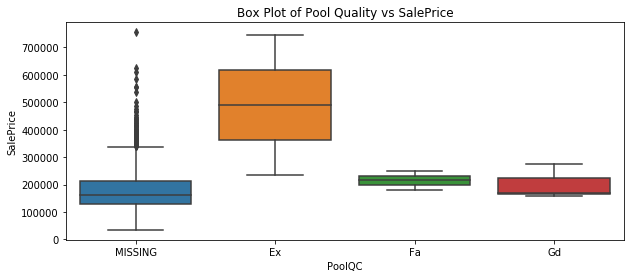

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Box Plot of Pool Quality vs SalePrice')
ax = sns.boxplot(x='PoolQC', y="SalePrice", data=data)

In [36]:
pool_quals = data['PoolQC'].unique()
all_pool_quals = [] 
for pool_qual in pool_quals:
    sales = data[data['PoolQC'] == pool_qual]['SalePrice'].values 
    all_pool_quals.append(sales)

# ANOVA test
pval = stats.f_oneway(*all_pool_quals)[1]
print('P-value:', pval)

P-value: 7.7009894157147e-07


Again, a p-value this small suggests that we can reject the null hypothesis and therefore conclude that there is a significance of the effect of the pool quality (and whether or not there is a pool) on the home's final sale price.

## Looking at the Big Picture

So far, I have only done analysis on the variables that I deemed interesting to me and that I personally think would have a big impact on `SalePrice`. However, data analysis shouldn't be subjective. I should also look at other variables that may be relevant in predicting `SalePrice`, which is what I will do now below.

A quick way to look at the overall picture and how the independent variables relate to `SalePrice` is by using a heatmap.

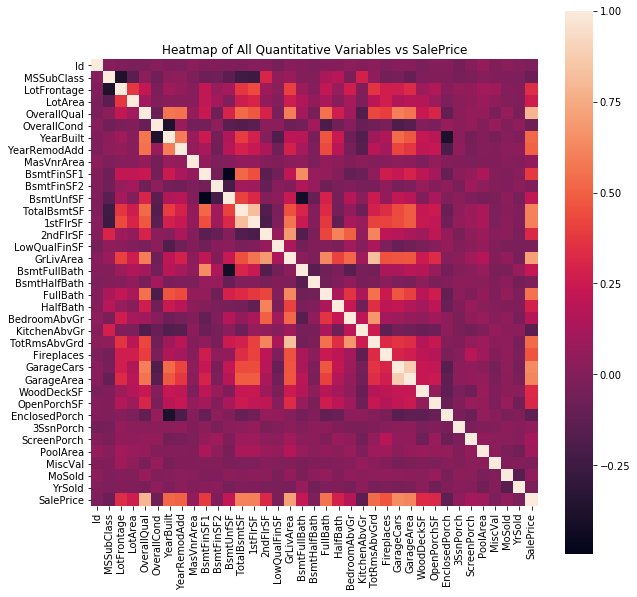

In [37]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(10, 10))
ax.set_title('Heatmap of All Quantitative Variables vs SalePrice')
sns.heatmap(corrmat, vmax=1, square=True);

Here we can see an overall picture of which variables are highly correlated using the Pearson coefficient. Lighter colors signal a higher correlation between variables, whereas darker colors are less so.

Let's start by looking at which variables are highly correlated with `SalePrice`. An immediate variable that pops out is `OverallQual`. It is the lightest colored variable, suggesting it is highly correlated with `SalePrice` like I initially thought. Another variable is `GrLivArea`, which suggests that there is a high correlation between living area and a home's final price.

There is also signs of strong correlations between the independent variables. Examples of this include `GarageCars` and `GarageArea`. This makes sense given that larger garages can typically store more cars. So, it would be necessary to exclude one of these variables to avoid confounding. Another example is `1stFlrSF` and `TotalBsmtSF`. Again, the strong correlation is reasonable given that the first floor is typically above the basement of a home and situated on the roof of the basement, and so larger first floors would have larger basements underneath.

We can take a closer look at the variables most correlated with `SalePrice`.  

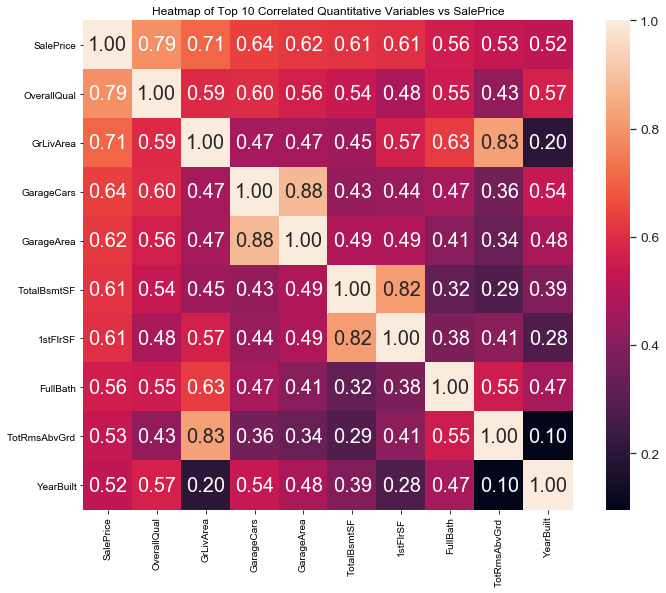

In [38]:
#saleprice correlation matrix
f, ax = plt.subplots(figsize=(12, 9))
ax.set_title('Heatmap of Top 10 Correlated Quantitative Variables vs SalePrice')
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, 
                 square=True, fmt='.2f', annot_kws={'size': 20}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Above are the 10 features most correlated with `SalePrice`. My intuition that `OverallQual` was relevant in determining `SalePrice` is supported by the fact that it is the most correlated variable with `SalePrice`. We also see that the size of the garage may have a bigger impact on final sales price that I had initially thought.

Note that these heatmaps only map the quantitative variables. We would have to use a different method in order to see how the other qualitative variables relate to `SalePrice`.

The plan to visualize the correlations of the various categorical variables involves encoding these variables. There are many ways to encode categorical variables. A common method is [One-Hot Encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f), which involves creating multiple, new columns for each level of the categorical variable. Each of these columns would have a '1' if the observation expressed that level, or '0' otherwise. This is good for nominal data, which a majority of the categorical variables in this dataset seems to be. 

However, for the sake of analyzing these categorical variables, it would be easier to encode the categorical variables using ordinal encoding, where each level is mapped to a specific integer. Of course, I said before that most of these variables are nominal i.e. there is no clear ordering in the different levels. For example, `Neighborhood` lists the different neighborhoods these homes can be found, and there is no clear way of finding an order amongst these choices. 

So, what will be done, and what is shown [here](https://www.kaggle.com/dgawlik/house-prices-eda/notebook), is derive an order from the data based on the mean `SalePrice` for each level of the variable. Lower integer mappings correspond to a smaller average `SalePrice`, whereas larger integer mappings represent a larger average `SalePrice`. In fact, I will use this encoding for the final model.

In [39]:
# Get the categorical and variables 
qualitative = [feat for feat in data.columns if data[feat].dtype == 'object']

def encode(frame, feature):
    """
    Encodes the categorical variables using ordinal encoding based on the magnitude of the average SalePrice.
    A higher average SalePrice for a particular level is mapped to a larger integer, and vice versa.
    
    Params:
      frame - The name of the DataFrame where the data resides.
      feature - The name of the feature to encode.
    """
    # Get the average SalePrice for each level and sort
    avgs = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    avgs = avgs.sort_values() # Sort the averages in ascending order
    # Create a mapping as a dictionary where keys are labels and values are integers
    mapping = range(1, len(avgs) + 1)
    enc_dict = {}
    i = 0
    for f in avgs.index:
        enc_dict[f]  = mapping[i]
        i = i + 1
    
    for category, mapping in enc_dict.items():
        # Create a new column using the integer mapping sorted by average SalePrice
        frame.loc[frame[feature] == category, feature+'_E'] = mapping

In [40]:
qual_enc = []
for q in qualitative:  
    encode(data, q)
    qual_enc.append(q+'_E')
print(qual_enc)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageYrBlt_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


With this encoding done, the categorical variables of interest (which are denoted with a '\_E' at the end) are encoded with integers. Now, we can visualize the correlations between these categorical variables and `SalePrice`.

### Encoding Categorical Data

In [41]:
def visualize_categorical_corr(frame, features):
    """
    Plot a graph to visualize the correlations between the encoded categorical variables and SalePrice.
    Since we transformed the categorical variables into ordinal variables ranked on the average SalePrice,
    we will use the Spearman correlation coefficient to visualize these variables.
    
    Params:
      frame - The DataFrame where the data can be found.
      features - The features to visualize.
    """
    corr_df = pd.DataFrame()
    corr_df['feature'] = features
    corr_df['corr'] = [frame[feat].corr(frame['SalePrice'], 'spearman') for feat in features]
    # Sort the correlations in ascending order
    corr_df = corr_df.sort_values('corr')
    f, ax = plt.subplots(figsize=(6, 0.25 * len(features)))
    ax.set_title('Barplot of Spearman Coefficient of Categorical Variables vs SalePrice')
    sns.barplot(data = corr_df, y = 'feature', x = 'corr', orient = 'h')

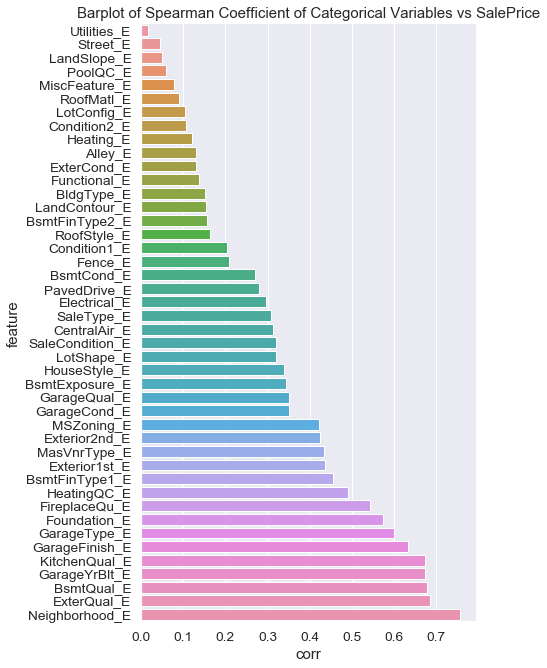

In [42]:
visualize_categorical_corr(data, qual_enc)

Above, you can see that the most heavily correlated categorical feature is `Neighborhood`, suggesting that the neighborhood a house resides in heavily influences the home's sales price.

Note that we are using a different correlation coefficient: the [Spearman Correlation Coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient). This correlation coefficient, unlike the default Pearson coefficient used for the quantitative variables, is better suited for ordinal variables, as it is able to evaulate the relationships involving ordinal variables. Since we transformed the categorical data to ordinal variables, it would be more appropriate to use the Spearman coefficient. A comparison of the Pearson and Spearman coefficients can be found [here](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/). 

## Numbers to Categories

Now that we have visualized the categorical and quantitative variables, we should now look back at the variables that should be categorical, but instead are recorded as numerical data, similar to `GarageYrBlt`. An example of this is `OverallQual` and `YrSold`. It would make more sense to label such variables as categorical and therefore discrete, since no houses can take on an overall quality of 7.5 or be sold in 2001.56. 

These variables include:
- `MSSubClass`
- `OverallQual`
- `OverallCond`
- `YearBuilt`
- `YearRemodAdd`
- `MoSold`
- `YrSold`

After transforming such variables, they will then need to be encoded using the same method before.

In [43]:
feats = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']

for feat in feats:
    # Cast them to Object
    data[feat] = data[feat].astype('object')
    
    # Encode
    encode(data, feat)
    
    qual_enc.append(feat + '_E')
    
quant = [feat for feat in quant if feat not in feats]

In [44]:
print(qual_enc)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageYrBlt_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E', 'MSSubClass_E', 'OverallQual_E', 'OverallCond_E', 'YearBuilt_E', 'YearRemodAdd_E', 'MoSold_E', 'YrSold_E']


## Transforming Non-Normal Quantitative Data

We will now move forward to transforming the non-normal quantitative variables using a log transformation. The reasons for doing this were listed above. 

In [45]:
quant_enc = [] # Records which variables are encoded

Recall that some variables had values of 0, which cannot be transformed via log. So, we must create a new boolean variable that captures whether or not a home has that particular feature or not. Then, on homes with the particular feature, we can log-transform the values.

In [46]:
bool_vars = []
for feat in [b_var for b_var in quant if 0 in data[b_var].values]:
    # Boolean encode
    data['Has_' + feat] = data[feat].apply(lambda x: 1 if x > 0 else 0)
    bool_vars.append('Has_' + feat)
    
    # Log transform
    _, p = stats.normaltest(data[feat])
    if(p < 0.05):
        data[feat + '_L']  = data[feat].apply(lambda x: np.log(abs(x)) if x > 0 else 0)
        quant_enc.append(feat + '_L')
    else:
        # Distribution already close to normal, so just add it to list of quant_enc
        quant_end.append(feat)

Now, we transform the rest of the quantitative variables if they are not normal. 

In [47]:
for feat in quant:
    if(feat + '_L' not in quant_enc):
        _, p = stats.normaltest(data[feat])
        if(p < 0.05):
            data[feat + '_L'] = np.log(abs(data[feat]))
            quant_enc.append(feat + '_L')
        else:
            quant_enc.append(feat)

In [48]:
print(quant_enc)

['MasVnrArea_L', 'BsmtFinSF1_L', 'BsmtFinSF2_L', 'BsmtUnfSF_L', 'TotalBsmtSF_L', '2ndFlrSF_L', 'LowQualFinSF_L', 'BsmtFullBath_L', 'BsmtHalfBath_L', 'FullBath_L', 'HalfBath_L', 'BedroomAbvGr_L', 'KitchenAbvGr_L', 'Fireplaces_L', 'GarageCars_L', 'GarageArea_L', 'WoodDeckSF_L', 'OpenPorchSF_L', 'EnclosedPorch_L', '3SsnPorch_L', 'ScreenPorch_L', 'PoolArea_L', 'MiscVal_L', 'LotFrontage_L', 'LotArea_L', '1stFlrSF_L', 'GrLivArea_L', 'TotRmsAbvGrd_L']


In [49]:
print(qual_enc)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageYrBlt_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E', 'MSSubClass_E', 'OverallQual_E', 'OverallCond_E', 'YearBuilt_E', 'YearRemodAdd_E', 'MoSold_E', 'YrSold_E']


In [50]:
print(bool_vars)

['Has_MasVnrArea', 'Has_BsmtFinSF1', 'Has_BsmtFinSF2', 'Has_BsmtUnfSF', 'Has_TotalBsmtSF', 'Has_2ndFlrSF', 'Has_LowQualFinSF', 'Has_BsmtFullBath', 'Has_BsmtHalfBath', 'Has_FullBath', 'Has_HalfBath', 'Has_BedroomAbvGr', 'Has_KitchenAbvGr', 'Has_Fireplaces', 'Has_GarageCars', 'Has_GarageArea', 'Has_WoodDeckSF', 'Has_OpenPorchSF', 'Has_EnclosedPorch', 'Has_3SsnPorch', 'Has_ScreenPorch', 'Has_PoolArea', 'Has_MiscVal']


## Conclusion

We have gone through the rigourous process of visualizing the independent variables and their relationship to `SalePrice` and preprocessing them.

We have also gone through the different methods of visualizing categorical variables, as well as explain reasons as to why we chose specific statistical techniques. Above we see graphs testing the normality of certain features, their correlations with `SalePrice`, and steps on how to properly encode them for use in our model.

More specifically, categorical variables were encoded ordinally using an order determined by mean `SalePrice`. Variables indicating an absence of were boolean encoded. Non-normal variables were subjected to a log-transformation.

In [51]:
print(len(quant_enc) + len(qual_enc) + len(bool_vars))

102


Above we see that the **I plan to use 102 features**, or all 79 of the original independent variables (excluding `SalePrice` and `Id`) plus 23 boolean variables. 

# Making the Model

Now, we can finally start making the model. Given that we are trying to predict a continuous variable (`SalePrice`), we should use a regression model. There are many different models to try out. I will first use a simple multivariable linear regression model. 

Recall that we also have to transform `SalePrice` using a log-transformation.

In [52]:
data['SalePrice_L'] = np.log(data['SalePrice'])

# Use linear regression
features = quant_enc + qual_enc + bool_vars
dep_var = 'SalePrice_L'

X = data[features].values
y = data[dep_var].values

reg = LinearRegression().fit(X, y)

preds = reg.predict(X)

In [53]:
# Calculate the root mean squared error
print('The root mean squared error is:', np.sqrt(np.mean(np.square(np.log(y) - np.log(preds)))))

The root mean squared error is: 0.009719039141518246


As you can see above, using linear regression on the default settings gets a root mean squared error of 0.009. This is actually pretty good, and so, for now, let's try using this simple linear regression model on the test set and see how well it performs on the Kaggle Leaderboard.

Note that we use this metric because it is the one used in the competition to evaluate sent-in scores. It is also appropriate for this model because **TODO**

## Pre-processing the Test Set

It is necessary to pre-process the test set the same way I pre-processed the training set.  

This includes:

- Dealing with missing values.
- Converting certain quantitative variables to categorical.
- Log-transforming the quantitative variables.
- Encoding the categorical variables.

In [54]:
test = pd.read_csv('test.csv')
test_qual = [f for f in test.columns if test[f].dtype == 'object']
test_quant = [f for f in test.columns if test[f].dtype != 'object']
test_quant.remove('Id')
print(test_quant)
print()
print(test_qual)

test_quant_enc = []
test_qual_enc = []
test_bool = []

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCo

### Test Set: Missing Values

Like the training data, there exists some missing variables. I will give the same treatment to these variables as I have done with the training data. The additional variables that are also missing values in the test set but not in the training set will need a more in-depth analysis to figure out how to deal with them.

In [55]:
test_missing = test.isnull().sum()
test_missing = test_missing[test_missing > 0]
test_missing = test_missing.sort_values(ascending = False)

# Get the missing variables present in both the testing and training set
missing_vars = [feat for feat in test_missing.index if feat in missing.index]
print(missing_vars)

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage', 'GarageYrBlt', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MasVnrArea']


In [56]:
# Get the categorical variables 
categ_vars = [var for var in missing_vars if data[var].dtype == 'object']
print(categ_vars)

# Impute the missing variables as a new category
for categ_var in categ_vars:
    test[categ_var] = test[categ_var].fillna('MISSING')

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageYrBlt', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']


In [57]:
# Impute the quantitative variables with predictions
quant_vars = [var for var in missing_vars if data[var].dtype != 'object']
print(quant_vars)

for var in quant_vars:
    test.loc[test[var].isnull(), var] = impute_quant(test, var)

['LotFrontage', 'MasVnrArea']


Now, we can take a look at the rest of the missing variables.

I will deal with them the same way I dealt with the missing variables in the training set: by imputing the categorical variables with a new level and by imputing quantitative variables with a prediction.

In [58]:
test_missing = test.isnull().sum()
test_missing = test_missing[test_missing > 0]
test_missing = test_missing.sort_values(ascending = False)
print(test_missing)

new_missing_vars = test_missing.index

MSZoning        4
Functional      2
BsmtHalfBath    2
BsmtFullBath    2
Utilities       2
SaleType        1
GarageArea      1
GarageCars      1
KitchenQual     1
TotalBsmtSF     1
BsmtUnfSF       1
BsmtFinSF2      1
BsmtFinSF1      1
Exterior2nd     1
Exterior1st     1
dtype: int64


In [59]:
# Handle the missing categorical variables 
categ_vars = [var for var in new_missing_vars if data[var].dtype == 'object']
for categ_var in categ_vars:
    test[categ_var] = test[categ_var].fillna('MISSING')

In [60]:
# Impute the quantitative variables with predictions
quant_vars = [var for var in new_missing_vars if data[var].dtype != 'object']
print(quant_vars)

for var in quant_vars:
    test.loc[test[var].isnull(), var] = impute_quant(test, var)

['BsmtHalfBath', 'BsmtFullBath', 'GarageArea', 'GarageCars', 'TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF2', 'BsmtFinSF1']


### Test Set: Encoding the Categorical Variables

Now that the missing values have been dealt with, I can now attend to encoding the categorical variables.

To ensure that the two datasets are similar, I will map the levels of the test set with the same mapping I got from the training set. For instance, if in the training set a `PoolQC` of _Ex_ was assigned an integer mapping of *5*, then all entries with a `PoolQC` of _Ex_ in the test set will be mapped to a _5_.

In [61]:
# Encode each categorical variable
for f in test_qual:
    # Create mapping
    mapping = {}
    for level in data[f].unique():
        mapping[level] = data[data[f] == level][f + '_E'].values[0]
        
    for level, int_mapping in mapping.items():
        test.loc[test[f] == level, f + '_E'] = int_mapping
    
    test_qual_enc.append(f + '_E')

Keep in mind that we also have to transform the quantitative variables that should be categorical, and then encode them.

In [62]:
feats = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'GarageYrBlt']

for feat in feats:
    # Cast them to Object
    test[feat] = test[feat].astype('object')
    test_quant.remove(feat)

In [63]:
# Encode these variables
for f in feats:
    # Create mapping
    mapping = {}
    for level in data[f].unique():
        mapping[level] = data[data[f] == level][f + '_E'].values[0]
        
    for level, int_mapping in mapping.items():
        test.loc[test[f] == level, f + '_E'] = int_mapping
    
    test_qual_enc.append(f + '_E')

In [64]:
print(test_qual_enc)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E', 'MSSubClass_E', 'OverallQual_E', 'OverallCond_E', 'YearBuilt_E', 'YearRemodAdd_E', 'MoSold_E', 'YrSold_E', 'GarageYrBlt_E']


### Test Set: Log-Transformations

Now, I will log-transform the necessary quantitative variables.

In [65]:
# Boolean encode
for feat in [b_var for b_var in test_quant if 0 in test[b_var].values]:
    test['Has_' + feat] = test[feat].apply(lambda x: 1 if x > 0 else 0)
    test_bool.append('Has_' + feat)
    
    # Log transform
    test[feat + '_L']  = test[feat].apply(lambda x: np.log(abs(x)) if x > 0 else 0)
    test_quant_enc.append(feat + '_L')

In [66]:
# Log transform
for feat in test_quant:
    if(feat + '_L' not in test_quant_enc):
        test[feat + '_L'] = np.log(abs(test[feat]))
        test_quant_enc.append(feat + '_L')

In [67]:
print(test_quant_enc)

print()

print(test_bool)

['MasVnrArea_L', 'BsmtFinSF1_L', 'BsmtFinSF2_L', 'BsmtUnfSF_L', 'TotalBsmtSF_L', '2ndFlrSF_L', 'LowQualFinSF_L', 'BsmtFullBath_L', 'BsmtHalfBath_L', 'FullBath_L', 'HalfBath_L', 'BedroomAbvGr_L', 'KitchenAbvGr_L', 'Fireplaces_L', 'GarageCars_L', 'GarageArea_L', 'WoodDeckSF_L', 'OpenPorchSF_L', 'EnclosedPorch_L', '3SsnPorch_L', 'ScreenPorch_L', 'PoolArea_L', 'MiscVal_L', 'LotFrontage_L', 'LotArea_L', '1stFlrSF_L', 'GrLivArea_L', 'TotRmsAbvGrd_L']

['Has_MasVnrArea', 'Has_BsmtFinSF1', 'Has_BsmtFinSF2', 'Has_BsmtUnfSF', 'Has_TotalBsmtSF', 'Has_2ndFlrSF', 'Has_LowQualFinSF', 'Has_BsmtFullBath', 'Has_BsmtHalfBath', 'Has_FullBath', 'Has_HalfBath', 'Has_BedroomAbvGr', 'Has_KitchenAbvGr', 'Has_Fireplaces', 'Has_GarageCars', 'Has_GarageArea', 'Has_WoodDeckSF', 'Has_OpenPorchSF', 'Has_EnclosedPorch', 'Has_3SsnPorch', 'Has_ScreenPorch', 'Has_PoolArea', 'Has_MiscVal']


## Using All Features

Now that we have encoded all the features, we can get to creating the model.

These feature sets should be the same.

In [68]:
test_features = test_quant_enc + test_qual_enc + test_bool
print(test_features)

['MasVnrArea_L', 'BsmtFinSF1_L', 'BsmtFinSF2_L', 'BsmtUnfSF_L', 'TotalBsmtSF_L', '2ndFlrSF_L', 'LowQualFinSF_L', 'BsmtFullBath_L', 'BsmtHalfBath_L', 'FullBath_L', 'HalfBath_L', 'BedroomAbvGr_L', 'KitchenAbvGr_L', 'Fireplaces_L', 'GarageCars_L', 'GarageArea_L', 'WoodDeckSF_L', 'OpenPorchSF_L', 'EnclosedPorch_L', '3SsnPorch_L', 'ScreenPorch_L', 'PoolArea_L', 'MiscVal_L', 'LotFrontage_L', 'LotArea_L', '1stFlrSF_L', 'GrLivArea_L', 'TotRmsAbvGrd_L', 'MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'Garage

In [69]:
print('Variables not on test_features but in features:', [f for f in features if f not in test_features])

Variables not on test_features but in features: []


In [70]:
# Using the trained model from before, make predictions on the SalePrice of the test set
test_X = test[features].fillna(0.).values
test_preds = reg.predict(test_X)

In [73]:
# Now, we can submit the predictions
homeId = test['Id']
submission = pd.DataFrame({
    'Id': homeId,
    'SalePrice': math.e**test_preds
})
submission.to_csv('submissions.csv')

In [74]:
test[test_features].isna().sum().sort_values(ascending = False)

YearBuilt_E          9
GarageYrBlt_E        7
MSZoning_E           4
Utilities_E          2
Functional_E         2
MSSubClass_E         1
Exterior2nd_E        1
Exterior1st_E        1
SaleType_E           1
KitchenQual_E        1
TotRmsAbvGrd_L       0
Street_E             0
Alley_E              0
LotShape_E           0
LandContour_E        0
Neighborhood_E       0
LotConfig_E          0
LandSlope_E          0
1stFlrSF_L           0
Condition1_E         0
Condition2_E         0
BldgType_E           0
HouseStyle_E         0
RoofStyle_E          0
RoofMatl_E           0
MasVnrType_E         0
GrLivArea_L          0
Has_MiscVal          0
ExterCond_E          0
LotArea_L            0
                    ..
Has_WoodDeckSF       0
Has_OpenPorchSF      0
Has_EnclosedPorch    0
Has_3SsnPorch        0
Has_ScreenPorch      0
Has_MasVnrArea       0
MoSold_E             0
BsmtQual_E           0
GarageType_E         0
Has_PoolArea         0
BsmtExposure_E       0
BsmtFinType1_E       0
BsmtFinType

In [75]:
# Some mappings don't exist in the training set but exist in the test set
test[test['YearBuilt_E'].isna()]['YearBuilt']

98      1907
142     1896
374     1902
757     1895
966     1895
991     1879
1007    1901
1008    1901
1119    1895
Name: YearBuilt, dtype: object

# Looking Back: Different Approaches

## One-Hot Encoding

## Using Most Correlated Features

## Forward Step-Wise Regression